## Split CIFAR-10 into training, validation, and testing sets


In [1]:
# !mamba create -n py311 -y
# !source /opt/conda/bin/activate py311 && mamba install python=3.11 jupyter mamba -y

# !sudo rm /opt/conda/bin/python3
# !sudo ln -sf /opt/conda/envs/py311/bin/python3 /opt/conda/bin/python3
# !sudo rm /opt/conda/bin/python3.7
# !sudo ln -sf /opt/conda/envs/py311/bin/python3 /opt/conda/bin/python3.7
# !sudo rm /opt/conda/bin/python
# !sudo ln -sf /opt/conda/envs/py311/bin/python3 /opt/conda/bin/python

# !python --version

In [2]:
import random
import torch
import numpy as np

SEED = 1234

# Ensure reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(SEED)

In [3]:
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import multiprocessing

batch_size=128
num_workers=multiprocessing.cpu_count()

print("Number of workers: " + str(num_workers))

torch.set_num_threads(num_workers)
train_on_gpu = torch.cuda.is_available()

train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(
            degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)
        ),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)



dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, pin_memory=True, shuffle=True, num_workers=num_workers,
    worker_init_fn=lambda worker_id: set_seed(SEED + worker_id),
    generator=torch.Generator().manual_seed(SEED)
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, pin_memory=True, shuffle=False, num_workers=num_workers,
    worker_init_fn=lambda worker_id: set_seed(SEED + worker_id),
    generator=torch.Generator().manual_seed(SEED)
)

test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_transform
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
)

classes = [
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]


Number of workers: 4


100%|██████████| 170498071/170498071 [00:02<00:00, 61321554.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualize image for each class


In [4]:
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "figure.figsize": (8, 6),
        "axes.labelsize": 12,
        "axes.titlesize": 14,
        "legend.fontsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
)

%matplotlib inline

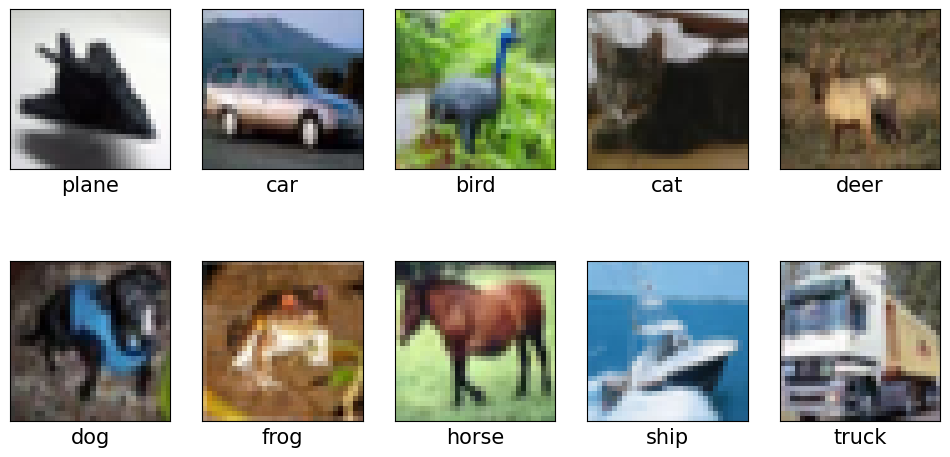

In [5]:

# visualize training image for each class
sample_images = [
    dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)
]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
    for axis in row:
        axis.set_xticks([])
        axis.set_yticks([])
        axis.set_xlabel(classes[i], fontsize=15)
        axis.imshow(sample_images[i])
        i += 1

## Define CNN architecture


In [6]:
import os
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
        self.conv2 = nn.Conv2d(128, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.bn_conv1 = nn.BatchNorm2d(128)
        self.bn_conv2 = nn.BatchNorm2d(128)
        self.bn_conv3 = nn.BatchNorm2d(256)
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.bn_dense1 = nn.BatchNorm1d(1024)
        self.bn_dense2 = nn.BatchNorm1d(512)
        self.dropout_conv = nn.Dropout2d(p=0.25)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def conv_layers(self, x):
        out = F.relu(self.bn_conv1(self.conv1(x)))
        out = F.relu(self.bn_conv2(self.conv2(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)
        out = F.relu(self.bn_conv3(self.conv3(out)))
        out = F.relu(self.bn_conv4(self.conv4(out)))
        out = self.pool(out)
        out = self.dropout_conv(out)
        return out

    def dense_layers(self, x):
        out = F.relu(self.bn_dense1(self.fc1(x)))
        out = self.dropout(out)
        out = F.relu(self.bn_dense2(self.fc2(out)))
        out = self.dropout(out)
        out = self.fc3(out)
        return out

    def forward(self, x):
        out = self.conv_layers(x)
        out = out.view(-1, 256 * 8 * 8)
        out = self.dense_layers(out)
        return out

class BaseNet(nn.Module):
    """Base class for neural network models."""

    def save(self, fname):
        # Extract the directory path from the file name
        dir_path = os.path.dirname(fname)

        # Check if the directory path is not empty
        if dir_path:
            # Check if the directory exists, and create it if it does not
            if not os.path.exists(dir_path):
                os.makedirs(dir_path, exist_ok=True)

        # Save the model
        torch.save(self.state_dict(), fname)

    def load(self, fname, device):
        self.load_state_dict(torch.load(fname, map_location=device))
        self.eval()

class CIFAR_CNN(nn.Module):
    def __init__(self):
        super(CIFAR_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNN(BaseNet):
    """A more advanced CNN for CIFAR-10 / CIFAR-100."""

    def __init__(self, num_classes):
        super().__init__()
        # network layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding="same")
        self.conv2 = nn.Conv2d(64, 64, 3, padding="same")
        self.conv3 = nn.Conv2d(64, 128, 3, padding="same")
        self.conv4 = nn.Conv2d(128, 128, 3, padding="same")
        self.conv5 = nn.Conv2d(128, 256, 3, padding="same")
        self.conv6 = nn.Conv2d(256, 256, 3, padding="same")

        # Residual connections with pre-activation
        self.res1 = ResidualBlock(64, 64)
        self.res2 = ResidualBlock(128, 128)
        self.res3 = ResidualBlock(256, 256)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)
        self.bn6 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self.drop = nn.Dropout(0.25)

    # forward pass of the data "x"
    def forward(self, x):
        # Input: 3x32x32
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = self.pool(x)
        x = self.drop(x)
        # Output: 64x16x16

        # Input: 64x16x16
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.res2(x)
        x = self.pool(x)
        x = self.drop(x)
        # Output: 128x8x8

        # Input: 128x8x8
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.res3(x)
        x = self.pool(x)
        x = self.drop(x)
        # Output: 256x4x4

        # Input: 256x4x4
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # "softmax" activation will be automatically applied in the cross entropy loss below,
        # see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding="same")
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding="same")
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

# class CNN(BaseNet):
#     """A simple CNN for CIFAR-10 / CIFAR-100."""

#     def __init__(self, num_classes):
#         super().__init__()
#         # network layers
#         self.conv1 = nn.Conv2d(3, 32, 3, padding="same")
#         self.conv2 = nn.Conv2d(32, 32, 3, padding="same")
#         self.conv3 = nn.Conv2d(32, 64, 3, padding="same")
#         self.conv4 = nn.Conv2d(64, 64, 3, padding="same")
#         self.conv5 = nn.Conv2d(64, 128, 3, padding="same")
#         self.conv6 = nn.Conv2d(128, 128, 3, padding="same")

#         # Poor man's ResNet ...
#         # skip connections (learned 1x1 convolutions with stride=1)
#         self.skip2 = nn.Conv2d(32, 32, 1, stride=1, padding=0)
#         self.skip4 = nn.Conv2d(64, 64, 1, stride=1, padding=0)
#         self.skip6 = nn.Conv2d(128, 128, 1, stride=1, padding=0)

#         self.bn1 = nn.BatchNorm2d(32)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.bn3 = nn.BatchNorm2d(64)
#         self.bn4 = nn.BatchNorm2d(64)
#         self.bn5 = nn.BatchNorm2d(128)
#         self.bn6 = nn.BatchNorm2d(128)

#         self.pool = nn.MaxPool2d(2, 2)

#         self.fc1 = nn.Linear(128 * 4 * 4, 128)
#         self.fc2 = nn.Linear(128, num_classes)

#         self.drop = nn.Dropout(0.25)

#     # forward pass of the data "x"
#     def forward(self, x):
#         # Poor man's ResNet with residual connections

#         # For some reason, residual connections work better in this
#         # example with relu() applied before the addition and not after
#         # the addition as in the original ResNet paper.

#         # Input: 3x32x32
#         x = F.leaky_relu(self.bn1(self.conv1(x)))
#         x = self.skip2(x) + F.leaky_relu(self.bn2(self.conv2(x)))  # residual connection
#         x = self.pool(x)
#         x = self.drop(x)
#         # Output: 32x16x16

#         # Input: 32x16x16
#         x = F.leaky_relu(self.bn3(self.conv3(x)))
#         x = self.skip4(x) + F.leaky_relu(self.bn4(self.conv4(x)))  # residual connection
#         x = self.pool(x)
#         x = self.drop(x)
#         # Output: 64x8x8

#         # Input: 64x8x8
#         x = F.leaky_relu(self.bn5(self.conv5(x)))
#         x = self.skip6(x) + F.leaky_relu(self.bn6(self.conv6(x)))  # residual connection
#         x = self.pool(x)
#         x = self.drop(x)
#         # Output: 128x4x4

#         # Input: 128x4x4

#         x = torch.flatten(x, 1)  # flatten all dimensions except batch
#         x = F.leaky_relu(self.fc1(x))
#         x = self.fc2(x)
#         # "softmax" activation will be automatically applied in the cross entropy loss below,
#         # see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
#         return x


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# adam_net = Net().to(device)
# nadam_net = Net().to(device)
# exadam_net = Net().to(device)

# adam_net = CIFAR_CNN().to(device)
# nadam_net = CIFAR_CNN().to(device)
# exadam_net = CIFAR_CNN().to(device)

num_classes = len(classes)
adam_net = CNN(num_classes).to(device)
adamw_net = CNN(num_classes).to(device)
# nadam_net = CNN(num_classes).to(device)
exadam_net = CNN(num_classes).to(device)
sgd_net = CNN(num_classes).to(device)
adadelta_net = CNN(num_classes).to(device)
rmsprop_net = CNN(num_classes).to(device)

adam_num_params = sum(p.numel() for p in adam_net.parameters() if p.requires_grad)
print("Number of Adam trainable parameters:", adam_num_params)

adamw_num_params = sum(p.numel() for p in adamw_net.parameters() if p.requires_grad)
print("Number of AdamW trainable parameters:", adamw_num_params)

# nadam_num_params = sum(p.numel() for p in nadam_net.parameters() if p.requires_grad)
# print("Number of NAdam trainable parameters:", nadam_num_params)

exadam_num_params = sum(p.numel() for p in exadam_net.parameters() if p.requires_grad)
print("Number of EXAdam trainable parameters:", exadam_num_params)

sgd_num_params = sum(p.numel() for p in sgd_net.parameters() if p.requires_grad)
print("Number of SGD with momentum trainable parameters:", sgd_num_params)

adadelta_num_params = sum(p.numel() for p in adadelta_net.parameters() if p.requires_grad)
print("Number of Adadelta trainable parameters:", adadelta_num_params)

rmsprop_num_params = sum(p.numel() for p in rmsprop_net.parameters() if p.requires_grad)
print("Number of RMSProp trainable parameters:", rmsprop_num_params)

Device: cuda:0
Number of Adam trainable parameters: 3223882
Number of AdamW trainable parameters: 3223882
Number of EXAdam trainable parameters: 3223882
Number of SGD with momentum trainable parameters: 3223882
Number of Adadelta trainable parameters: 3223882
Number of RMSProp trainable parameters: 3223882


In [7]:
from typing import Any, Callable, Dict, Iterable, Optional, Tuple, Union, overload
import torch

Params = Union[Iterable[torch.Tensor], Iterable[Dict[str, Any]]]

class EXAdam(torch.optim.Optimizer):
    def __init__(
        self,
        params: Params,  # Model parameters
        lr: Union[float, torch.Tensor] = 0.001,  # Learning rate (default: 0.001)
        betas: Tuple[float, float] = (
            0.9,
            0.999,
        ),  # Coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
        eps: float = 1e-8,  # Epsilon value added to the denominator to improve numerical stability (default: 1e-8)
        weight_decay: float = 0.0,  # Weight decay (L2 penalty) (default: 0.0)
    ):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if betas[0] < 0.0 or betas[0] >= 1.0:
            raise ValueError("Invalid beta1 value: {}".format(betas[0]))
        if betas[1] < 0.0 or betas[1] >= 1.0:
            raise ValueError("Invalid beta2 value: {}".format(betas[1]))
        if eps < 0.0:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight decay: {}".format(weight_decay))

        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
        )
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)

    @overload
    def step(self, closure: None = ...) -> None:
        ...

    @overload
    def step(self, closure: Callable[[], float]) -> float:
        ...

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            lr: Union[float, torch.Tensor] = group["lr"]
            beta1: float
            beta2: float
            beta1, beta2 = group["betas"]
            eps: float = group["eps"]
            weight_decay: float = group["weight_decay"]
            for i, p in enumerate(group["params"]):
                if p.grad is None:
                    continue

                if p.grad.is_sparse:
                    raise RuntimeError(
                        "EXAdam does not support sparse gradients, please consider Sparsexadam instead"
                    )

                grad: torch.Tensor = p.grad.data

                state = self.state[p]

                if weight_decay != 0.0:
                    p.data.add_(p.data, alpha=lr * -weight_decay)

                if len(state) == 0:
                    state["step"] = 0
                    state["m"] = torch.zeros_like(p.data)
                    state["v"] = torch.zeros_like(p.data)

                m: torch.Tensor = state["m"]
                v: torch.Tensor = state["v"]

                state["step"] += 1

                step: int = state["step"]

                beta1_t: float = beta1**step
                beta2_t: float = beta2**step

                bias_correction1: float = 1 - beta1_t
                bias_correction2: float = 1 - beta2_t

                # Update biased first and second moment estimates
                m.mul_(beta1).add_(other=grad, alpha=1 - beta1)
                v.mul_(beta2).addcmul_(tensor1=grad, tensor2=grad, value=1 - beta2)

                # Compute the new debiasing terms
                d1: torch.Tensor = 1 + (v.div(v + eps)) * beta2_t
                d2: torch.Tensor = 1 + (m.pow(2).div(m.pow(2) + eps)) * beta1_t

                m_tilde: torch.Tensor = m.div(bias_correction1) * d1
                v_tilde: torch.Tensor = v.div(bias_correction2) * d2

                # Bias-corrected gradient
                g_tilde = grad.div(bias_correction1) * d1

                # Update the parameters
                theta: torch.Tensor = (
                    -lr * (m_tilde + g_tilde) / (v_tilde.sqrt() + eps)
                )

                p.data.add_(theta)

        return loss


## Training


In [8]:
import torch.optim as optim
import time

lr=1e-4

adam_optimizer = optim.Adam(params=adam_net.parameters(), lr=lr)
# nadam_optimizer = optim.NAdam(params=nadam_net.parameters(), lr=lr)
exadam_optimizer = EXAdam(params=exadam_net.parameters(), lr=lr)
adamw_optimizer = optim.AdamW(params=adamw_net.parameters(), lr=lr)
sgd_optimizer = optim.SGD(params=sgd_net.parameters(), lr=lr, momentum=0.9)
adadelta_optimizer = optim.Adadelta(params=adadelta_net.parameters(), lr=lr)
rmsprop_optimizer = optim.RMSprop(params=rmsprop_net.parameters(), lr=lr)



def train(net, optimizer, epochs=100):
    criterion = nn.CrossEntropyLoss()

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=5, verbose=True, min_lr=0
    )

    loss_hist, acc_hist = [], []
    loss_hist_val, acc_hist_val = [], []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        for data in train_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # compute training statistics
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            loss_item = loss.item()
            running_loss += loss_item

        avg_loss = running_loss / len(train_set)
        avg_acc = correct / len(train_set)
        loss_hist.append(avg_loss)
        acc_hist.append(avg_acc)

        # validation statistics
        net.eval()
        with torch.no_grad():
            loss_val = 0.0
            correct_val = 0
            for data in val_loader:
                batch, labels = data
                batch, labels = batch.to(device), labels.to(device)
                outputs = net(batch)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                loss_val += loss.item()
            avg_loss_val = loss_val / len(val_set)
            avg_acc_val = correct_val / len(val_set)
            loss_hist_val.append(avg_loss_val)
            acc_hist_val.append(avg_acc_val)
        net.train()

        scheduler.step(avg_loss_val)
        print(
            "[epoch %03d] loss: %.5f   accuracy: %.4f   val loss: %.5f   val accuracy: %.4f"
            % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val)
        )

    return loss_hist, acc_hist, loss_hist_val, acc_hist_val


def train_with_logging(net, optimizer, optimizer_name):
    print(f"\n>>> {optimizer_name} Started >>>")
    start_time = time.time()
    loss_hist, acc_hist, loss_hist_val, acc_hist_val = train(net, optimizer)
    end_time = time.time() - start_time
    print(f"Training Time for {optimizer_name}: {end_time}")
    return loss_hist, acc_hist, loss_hist_val, acc_hist_val

exadam_loss_hist, exadam_acc_hist, exadam_loss_hist_val, exadam_acc_hist_val = train_with_logging(exadam_net, exadam_optimizer, "EXAdam")
adamw_loss_hist, adamw_acc_hist, adamw_loss_hist_val, adamw_acc_hist_val = train_with_logging(adamw_net, adamw_optimizer, "AdamW")
adam_loss_hist, adam_acc_hist, adam_loss_hist_val, adam_acc_hist_val = train_with_logging(adam_net, adam_optimizer, "Adam")
adadelta_loss_hist, adadelta_acc_hist, adadelta_loss_hist_val, adadelta_acc_hist_val = train_with_logging(adadelta_net, adadelta_optimizer, "AdaDelta")
rmsprop_loss_hist, rmsprop_acc_hist, rmsprop_loss_hist_val, rmsprop_acc_hist_val = train_with_logging(rmsprop_net, rmsprop_optimizer, "RMSProp")
sgd_loss_hist, sgd_acc_hist, sgd_loss_hist_val, sgd_acc_hist_val = train_with_logging(sgd_net, sgd_optimizer, "SGD with Momentum")

# nadam_loss_hist, nadam_acc_hist, nadam_loss_hist_val, nadam_acc_hist_val = train_with_logging(nadam_net, nadam_optimizer, "NAdam")


>>> EXAdam Started >>>


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[epoch 001] loss: 0.01327   accuracy: 0.3877   val loss: 0.01069   val accuracy: 0.5116
[epoch 002] loss: 0.00876   accuracy: 0.5970   val loss: 0.00813   val accuracy: 0.6421
[epoch 003] loss: 0.00695   accuracy: 0.6834   val loss: 0.00935   val accuracy: 0.6143
[epoch 004] loss: 0.00608   accuracy: 0.7232   val loss: 0.00809   val accuracy: 0.6541
[epoch 005] loss: 0.00547   accuracy: 0.7522   val loss: 0.00738   val accuracy: 0.6820
[epoch 006] loss: 0.00499   accuracy: 0.7755   val loss: 0.00865   val accuracy: 0.6639
[epoch 007] loss: 0.00468   accuracy: 0.7902   val loss: 0.00539   val accuracy: 0.7676
[epoch 008] loss: 0.00439   accuracy: 0.8035   val loss: 0.00564   val accuracy: 0.7665
[epoch 009] loss: 0.00413   accuracy: 0.8157   val loss: 0.00503   val accuracy: 0.7869
[epoch 010] loss: 0.00393   accuracy: 0.8244   val loss: 0.00515   val accuracy: 0.7821
[epoch 011] loss: 0.00375   accuracy: 0.8309   val loss: 0.00456   val accuracy: 0.8070
[epoch 012] loss: 0.00359   accu

## Plotting training statistics


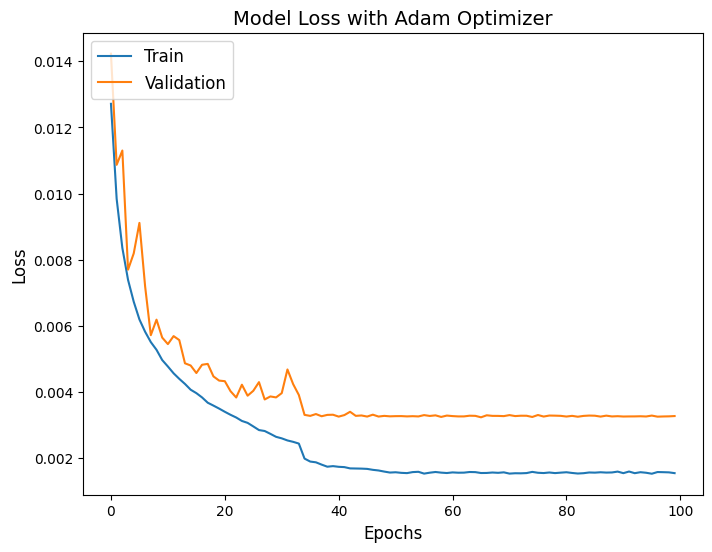

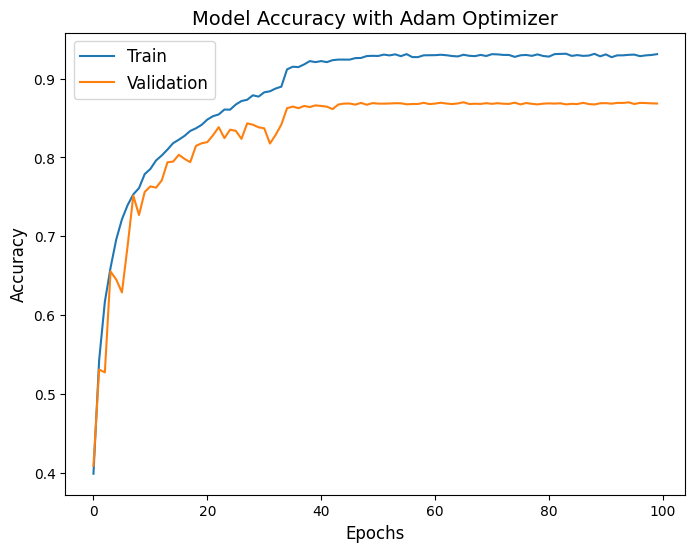

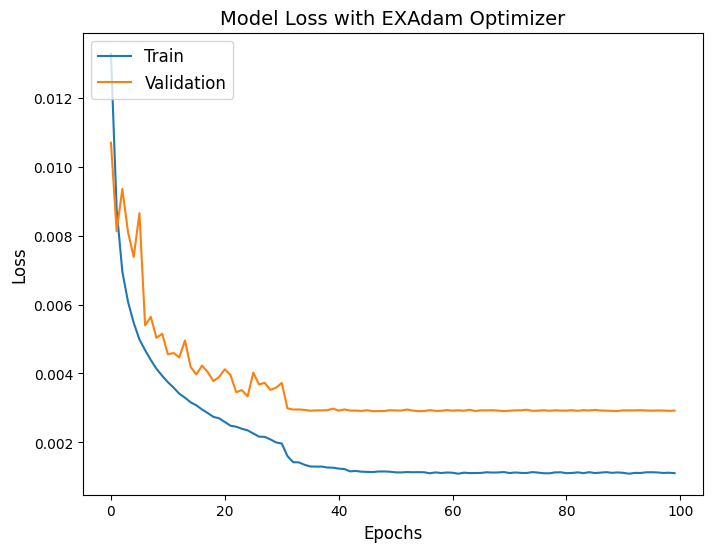

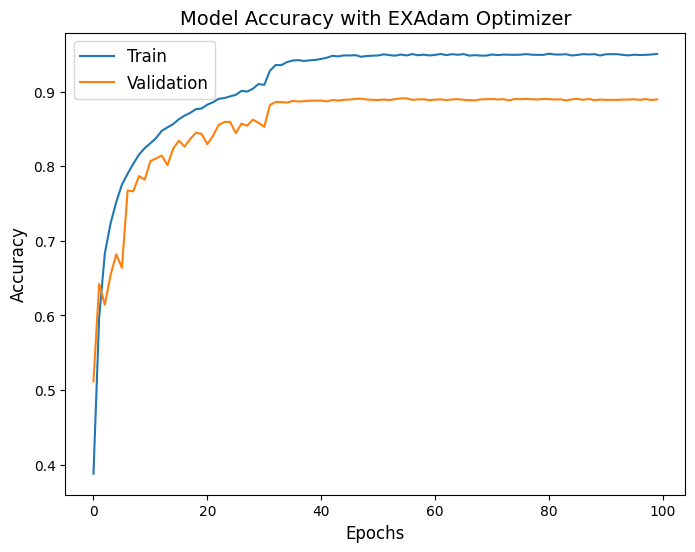

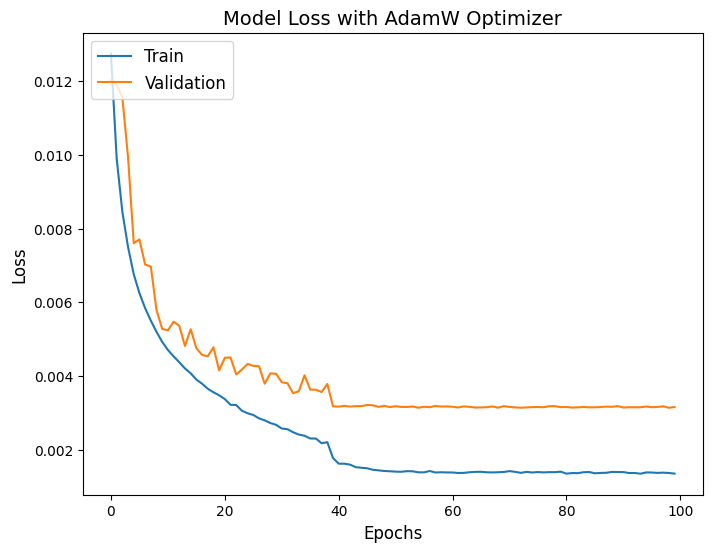

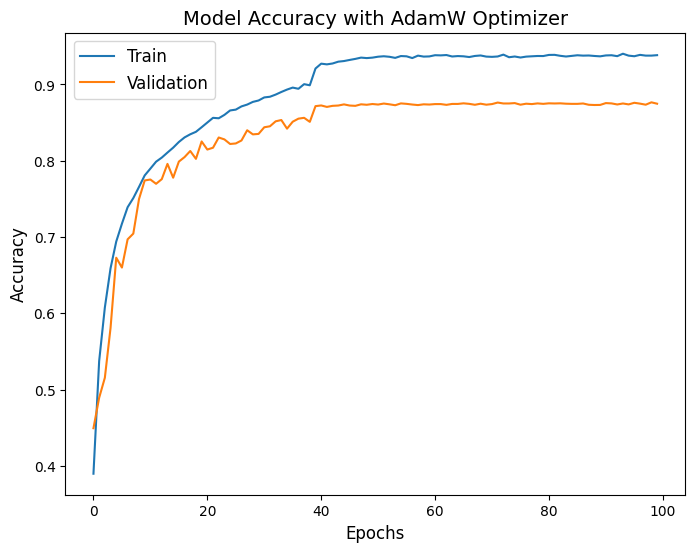

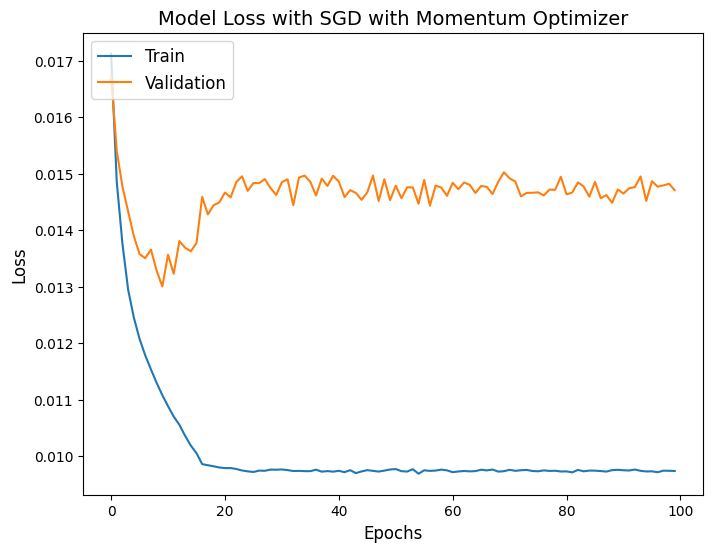

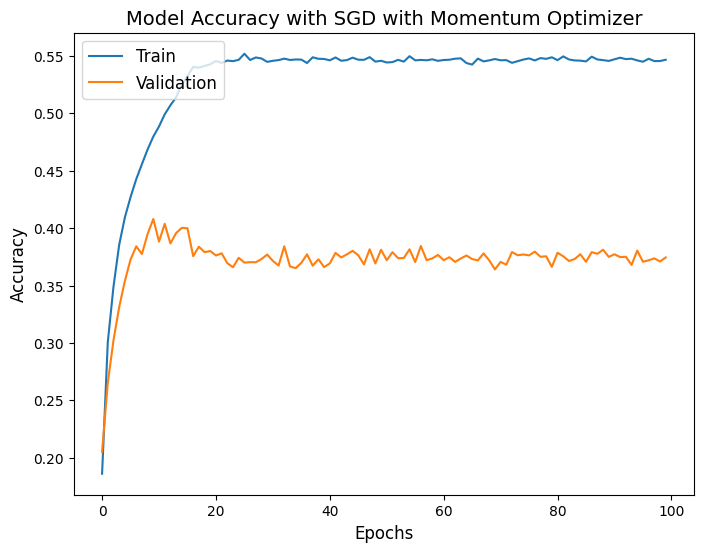

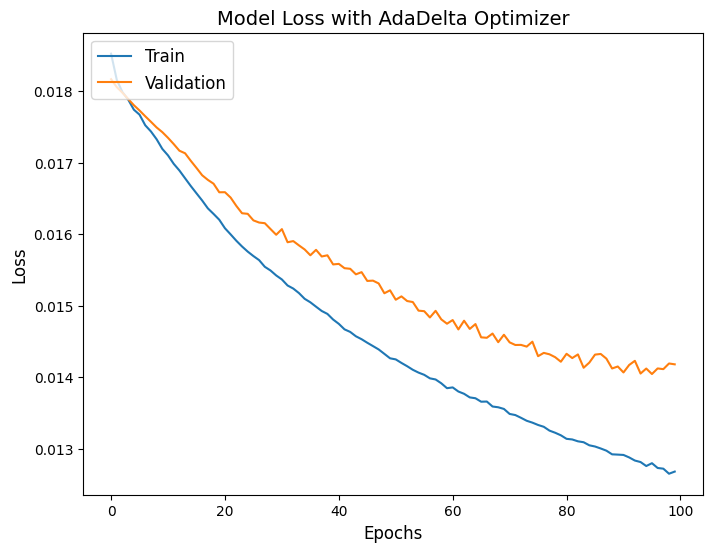

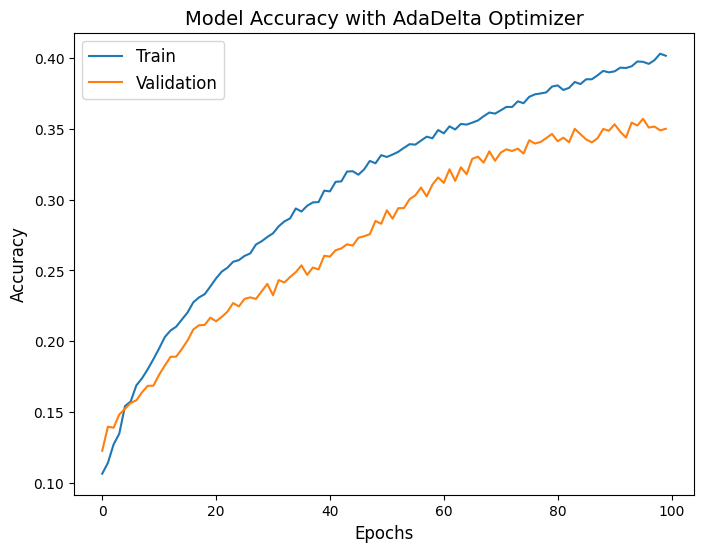

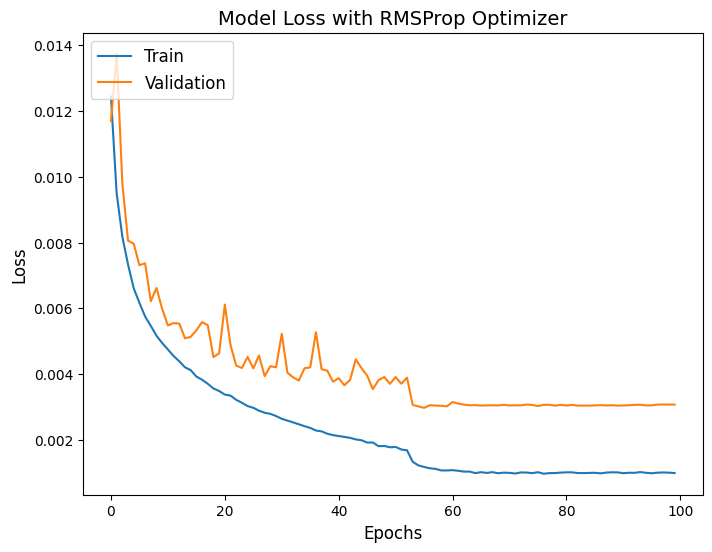

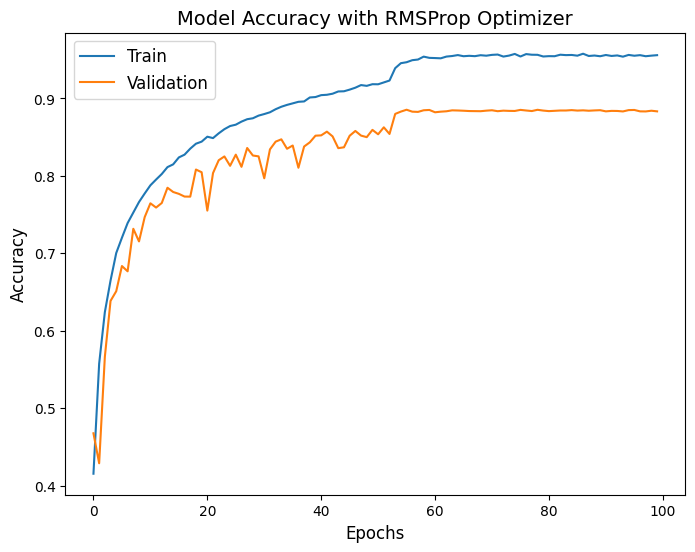

In [9]:
import matplotlib.pyplot as plt


def plot_loss(loss_hist, loss_hist_val, optimizer_name):
    legend = ["Train", "Validation"]
    plt.plot(loss_hist)
    plt.plot(loss_hist_val)
    plt.title("Model Loss with " + optimizer_name + " Optimizer")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(legend, loc="upper left")
    plt.show()


def plot_acc(acc_hist, acc_hist_val, optimizer_name):
    legend = ["Train", "Validation"]
    plt.plot(acc_hist)
    plt.plot(acc_hist_val)
    plt.title("Model Accuracy with " + optimizer_name + " Optimizer")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(legend, loc="upper left")
    plt.show()


plot_loss(adam_loss_hist, adam_loss_hist_val, "Adam")
plot_acc(adam_acc_hist, adam_acc_hist_val, "Adam")

# plot_loss(nadam_loss_hist, nadam_loss_hist_val, "NAdam")
# plot_acc(nadam_acc_hist, nadam_acc_hist_val, "NAdam")

plot_loss(exadam_loss_hist, exadam_loss_hist_val, "EXAdam")
plot_acc(exadam_acc_hist, exadam_acc_hist_val, "EXAdam")

plot_loss(adamw_loss_hist, adamw_loss_hist_val, "AdamW")
plot_acc(adamw_acc_hist, adamw_acc_hist_val, "AdamW")

plot_loss(sgd_loss_hist, sgd_loss_hist_val, "SGD with Momentum")
plot_acc(sgd_acc_hist, sgd_acc_hist_val, "SGD with Momentum")

plot_loss(adadelta_loss_hist, adadelta_loss_hist_val, "AdaDelta")
plot_acc(adadelta_acc_hist, adadelta_acc_hist_val, "AdaDelta")

plot_loss(rmsprop_loss_hist, rmsprop_loss_hist_val, "RMSProp")
plot_acc(rmsprop_acc_hist, rmsprop_acc_hist_val, "RMSProp")

## Save the trained model


In [10]:
# from google.colab import files

# torch.save(net.state_dict(), "checkpoint.pth")
# # download checkpoint file
# files.download("checkpoint.pth")

In [11]:
# net.load_state_dict(torch.load("checkpoint.pth"))

## Testing


In [12]:
def test_model(net, test_loader, optimizer_name):
    pred_vec = []
    net.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            outputs = net(batch)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_vec.append(predicted)
        pred_vec = torch.cat(pred_vec)

    accuracy = 100 * correct / total
    print(optimizer_name + " accuracy on the test set: %.2f %%" % accuracy)
    return pred_vec


adam_pred_vec=test_model(adam_net, test_loader, "Adam")
# nadam_pred_vec=test_model(nadam_net, test_loader, "NAdam")
exadam_pred_vec=test_model(exadam_net, test_loader, "EXAdam")
adamw_pred_vec=test_model(adamw_net, test_loader, "AdamW")
sgd_pred_vec=test_model(sgd_net, test_loader, "SGD with Momentum")
adadelta_pred_vec=test_model(adadelta_net, test_loader, "AdaDelta")
rmsprop_pred_vec=test_model(rmsprop_net, test_loader, "RMSProp")

Adam accuracy on the test set: 89.66 %
EXAdam accuracy on the test set: 90.83 %
AdamW accuracy on the test set: 89.71 %
SGD with Momentum accuracy on the test set: 43.13 %
AdaDelta accuracy on the test set: 37.45 %
RMSProp accuracy on the test set: 90.14 %


## Visualize wrongly classified image for each class


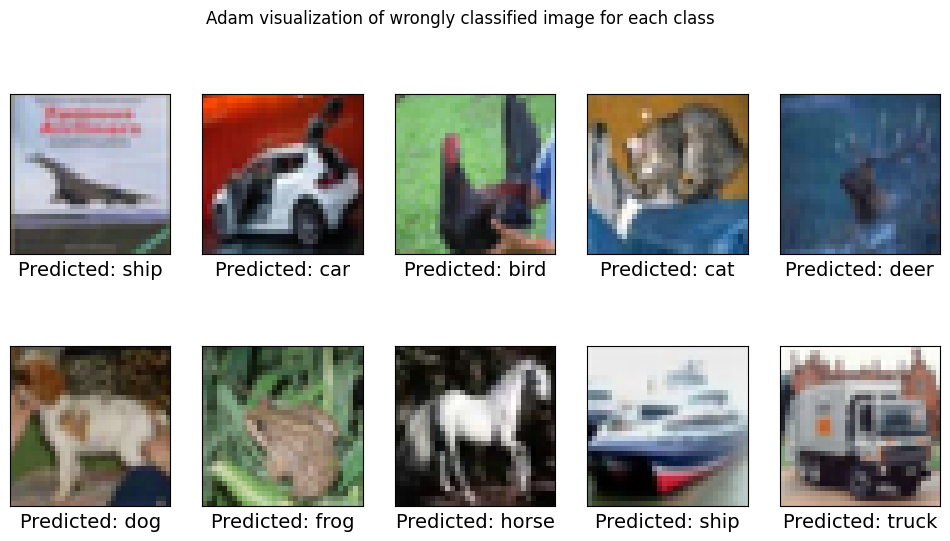

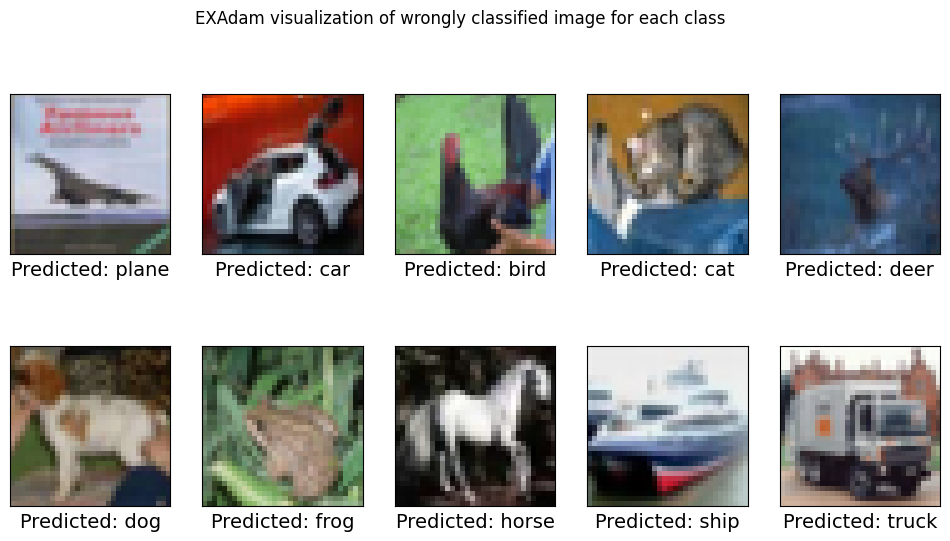

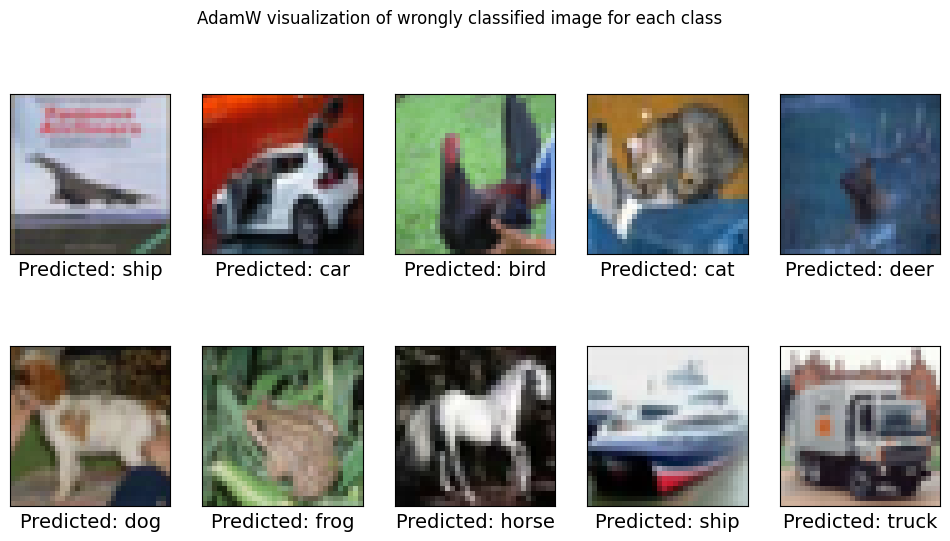

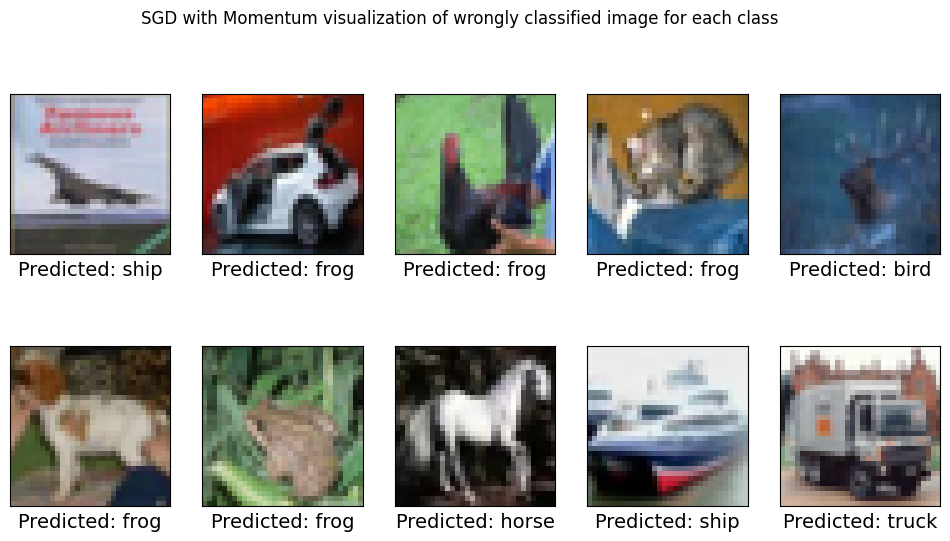

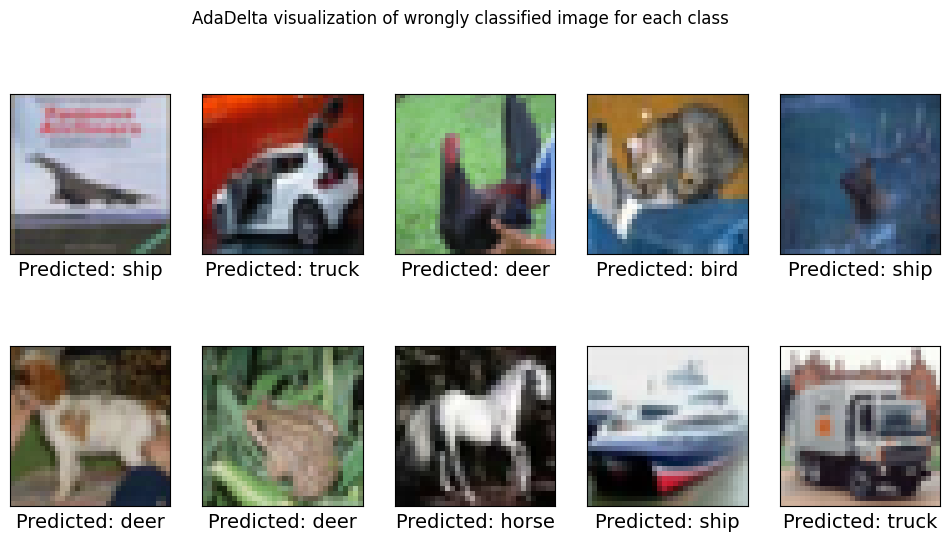

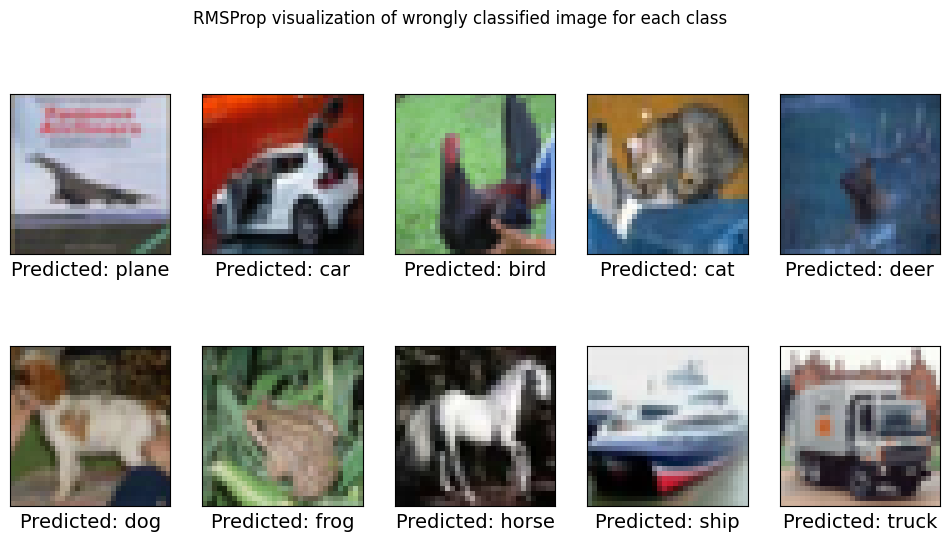

In [13]:
import numpy as np

# visualize wrongly classified image for each class
def visualize_wrongly_classifed(pred_vec, optim_name):
#     pred_vec = pred_vec.cpu().numpy()
    ground_truths = np.asarray(test_set.targets)
    incorrect_mask = pred_vec != ground_truths
    incorrect_images = [
        test_set.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)
    ]
    pred_results = [
        pred_vec[(ground_truths == label) & incorrect_mask][0] for label in range(10)
    ]

    # show images
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    i = 0
    fig.suptitle(optim_name+" visualization of wrongly classified image for each class")
    for row in axes:
        for axis in row:
            axis.set_xticks([])
            axis.set_yticks([])
            axis.set_xlabel("Predicted: %s" % classes[pred_results[i]], fontsize=14)
            axis.imshow(incorrect_images[i])
            i += 1
    
    fig.savefig(optim_name+'_visualization_wrongly_classified.png')

visualize_wrongly_classifed(adam_pred_vec,"Adam")
# visualize_wrongly_classifed(nadam_pred_vec,"NAdam")
visualize_wrongly_classifed(exadam_pred_vec,"EXAdam")
visualize_wrongly_classifed(adamw_pred_vec,"AdamW")
visualize_wrongly_classifed(sgd_pred_vec,"SGD with Momentum")
visualize_wrongly_classifed(adadelta_pred_vec,"AdaDelta")
visualize_wrongly_classifed(rmsprop_pred_vec,"RMSProp")


## Confusion matrix

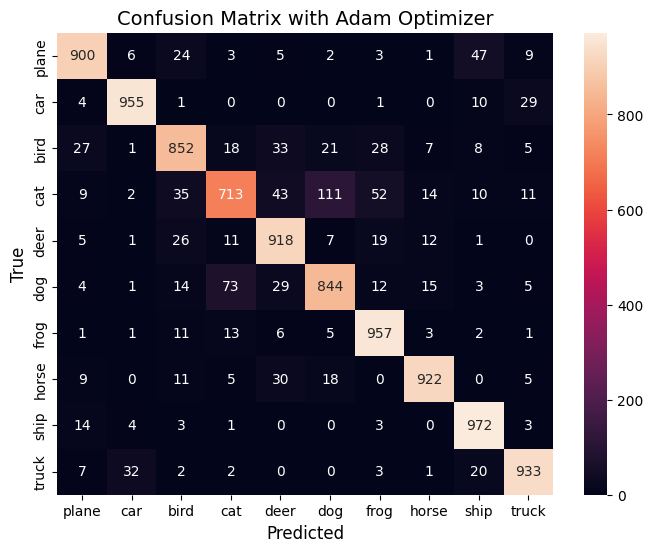

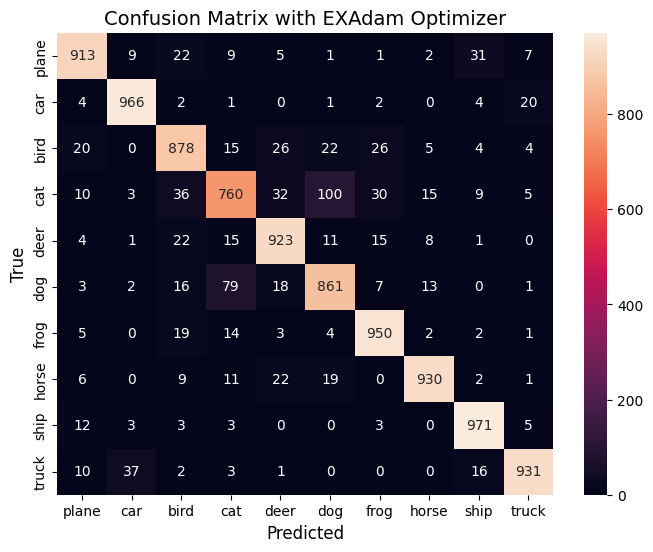

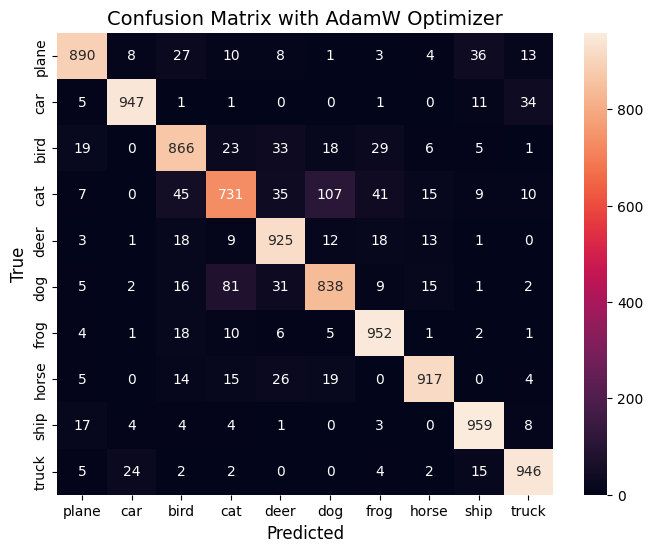

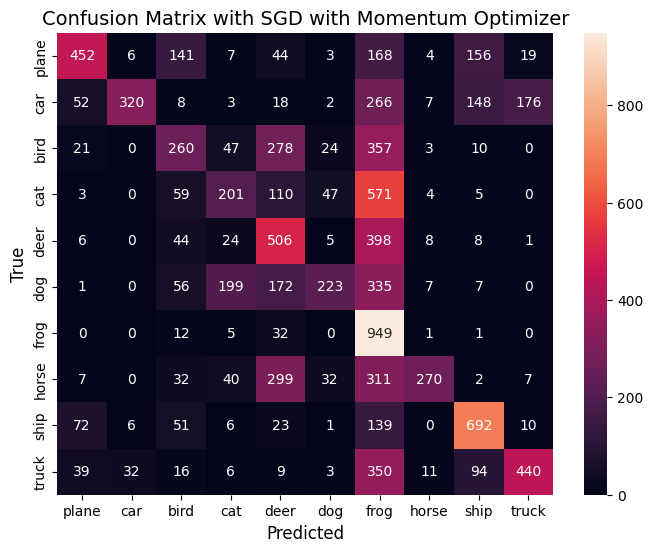

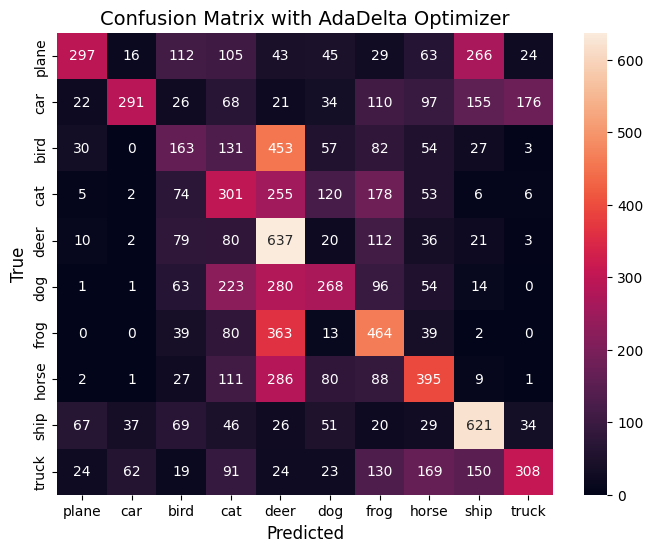

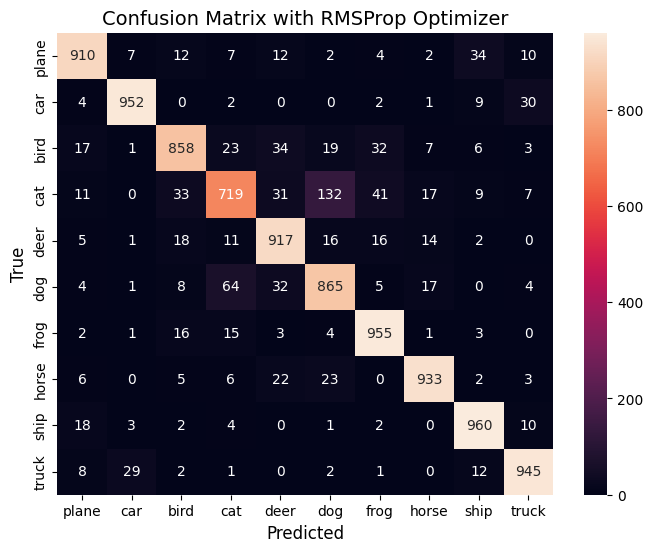

In [14]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(net, test_loader, optimizer_name):
    net.eval()
    pred_vec = []
    ground_truths = []

    with torch.no_grad():
        for data in test_loader:
            batch, labels = data
            batch, labels = batch.to(device), labels.to(device)
            outputs = net(batch)
            _, predicted = torch.max(outputs.data, 1)
            pred_vec.extend(predicted.cpu().numpy())
            ground_truths.extend(labels.cpu().numpy())

    cm = confusion_matrix(ground_truths, pred_vec)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix with " + optimizer_name + " Optimizer")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(optimizer_name+'_confusion_matrx.png')
    plt.show()
    return pred_vec

adam_pred_vec = plot_confusion_matrix(adam_net, test_loader, "Adam")
# nadam_pred_vec = plot_confusion_matrix(nadam_net, test_loader, "NAdam")
exadam_pred_vec = plot_confusion_matrix(exadam_net, test_loader, "EXAdam")
adamw_pred_vec = plot_confusion_matrix(adamw_net, test_loader, "AdamW")
sgd_pred_vec = plot_confusion_matrix(sgd_net, test_loader, "SGD with Momentum")
adadelta_pred_vec = plot_confusion_matrix(adadelta_net, test_loader, "AdaDelta")
rmsprop_pred_vec = plot_confusion_matrix(rmsprop_net, test_loader, "RMSProp")


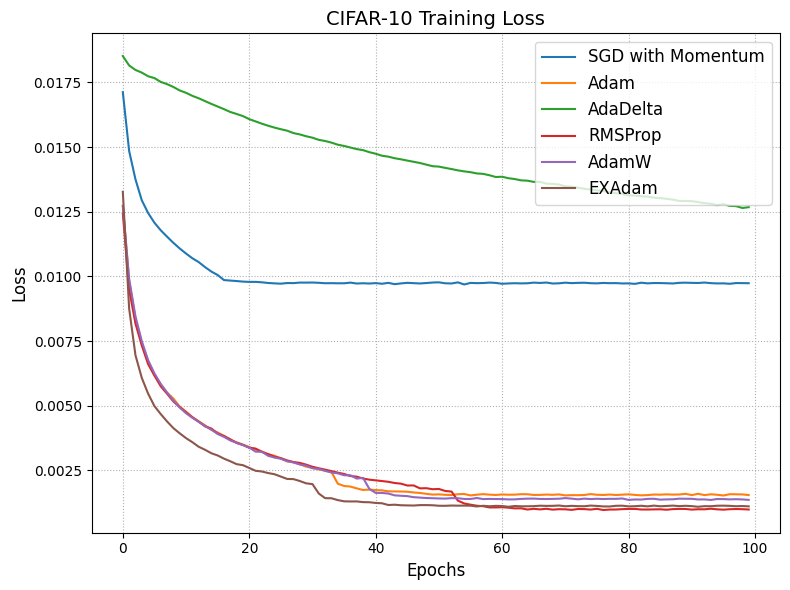

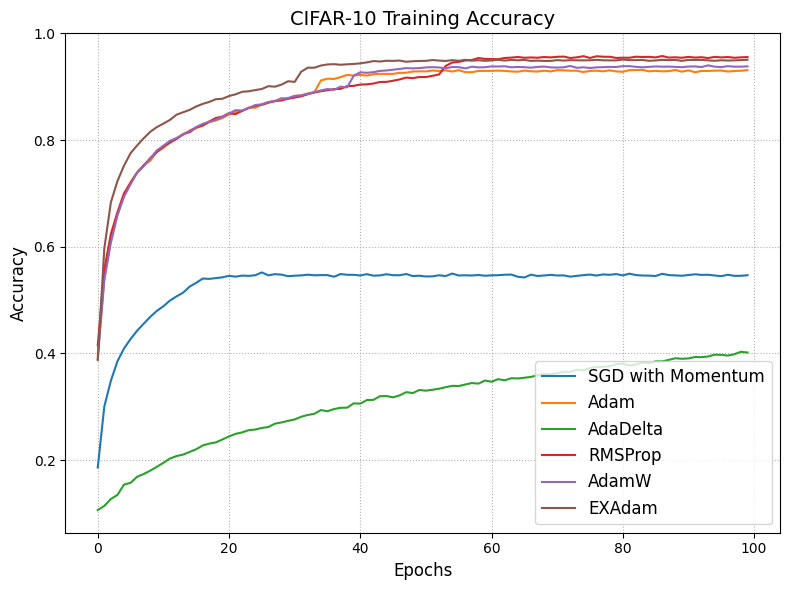

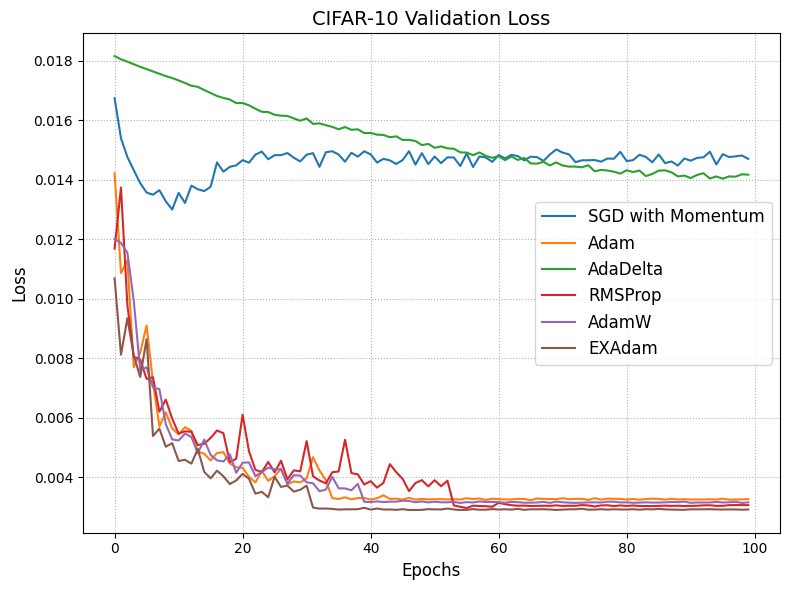

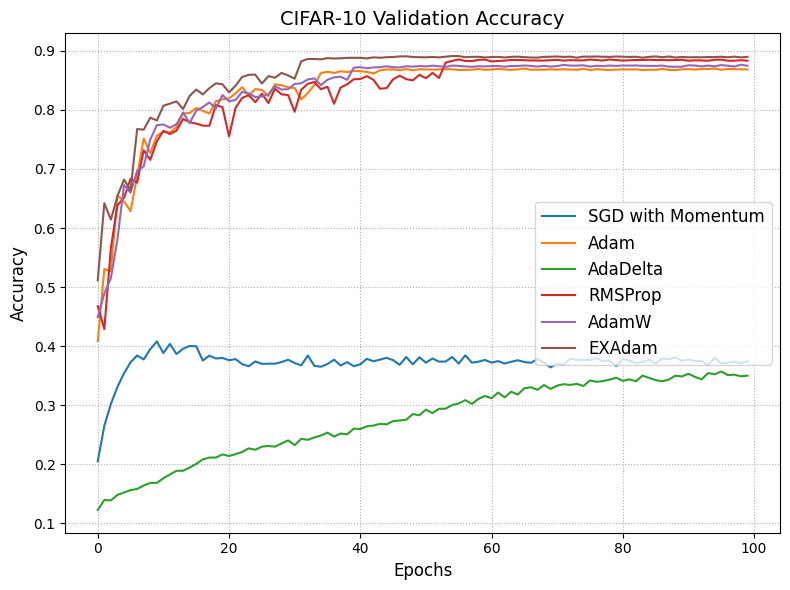

In [15]:
# plot Training loss of all optimizers
plt.figure(figsize=(8, 6))
plt.plot(sgd_loss_hist, label="SGD with Momentum")
plt.plot(adam_loss_hist, label="Adam")
plt.plot(adadelta_loss_hist, label="AdaDelta")
plt.plot(rmsprop_loss_hist, label="RMSProp")
# plt.plot(nadam_loss_hist, label="NAdam")
plt.plot(adamw_loss_hist, label="AdamW")
plt.plot(exadam_loss_hist, label="EXAdam")
plt.title("CIFAR-10 Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('CIFAR-10 Training Loss.png', dpi=300)
plt.show()

# plot Training accuracy of all optimizers
plt.figure(figsize=(8, 6))
plt.plot(sgd_acc_hist, label="SGD with Momentum")
plt.plot(adam_acc_hist, label="Adam")
plt.plot(adadelta_acc_hist, label="AdaDelta")
plt.plot(rmsprop_acc_hist, label="RMSProp")
# plt.plot(nadam_acc_hist, label="NAdam")
plt.plot(adamw_acc_hist, label="AdamW")
plt.plot(exadam_acc_hist, label="EXAdam")
plt.title("CIFAR-10 Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('CIFAR-10 Training Accuracy.png', dpi=300)
plt.show()

# plot Validation loss of all optimizers
plt.figure(figsize=(8, 6))
plt.plot(sgd_loss_hist_val, label="SGD with Momentum")
plt.plot(adam_loss_hist_val, label="Adam")
plt.plot(adadelta_loss_hist_val, label="AdaDelta")
plt.plot(rmsprop_loss_hist_val, label="RMSProp")
# plt.plot(nadam_loss_hist_val, label="NAdam")
plt.plot(adamw_loss_hist_val, label="AdamW")
plt.plot(exadam_loss_hist_val, label="EXAdam")
plt.title("CIFAR-10 Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('CIFAR-10 Validation Loss.png', dpi=300)
plt.show()

# plot Validation accuracy of all optimizers
plt.figure(figsize=(8, 6))
plt.plot(sgd_acc_hist_val, label="SGD with Momentum")
plt.plot(adam_acc_hist_val, label="Adam")
plt.plot(adadelta_acc_hist_val, label="AdaDelta")
plt.plot(rmsprop_acc_hist_val, label="RMSProp")
# plt.plot(nadam_acc_hist_val, label="NAdam")
plt.plot(adamw_acc_hist_val, label="AdamW")
plt.plot(exadam_acc_hist_val, label="EXAdam")
plt.title("CIFAR-10 Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('CIFAR-10 Validation Accuracy.png', dpi=300)
plt.show()

## Calculate Convergence Speed

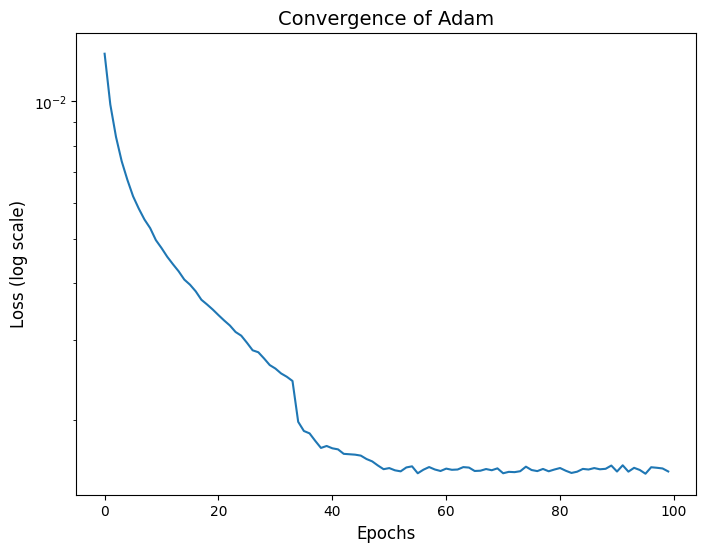

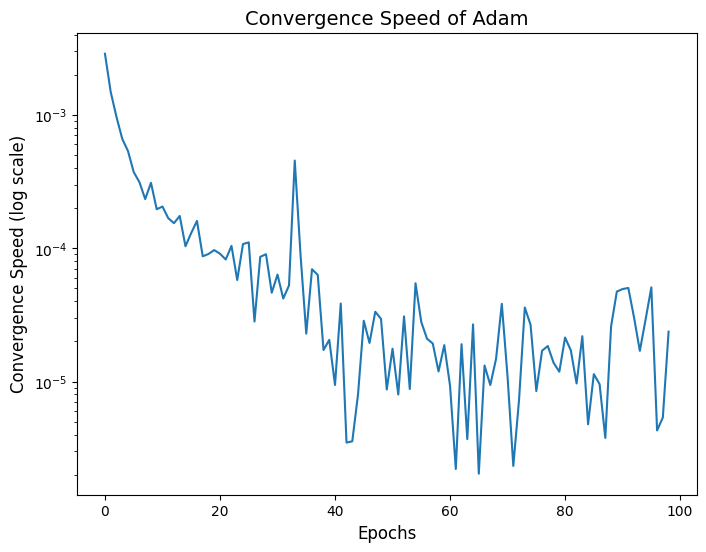

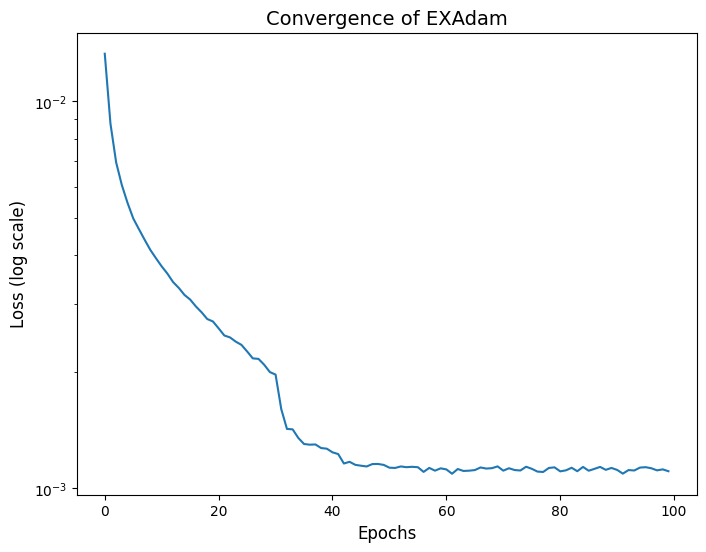

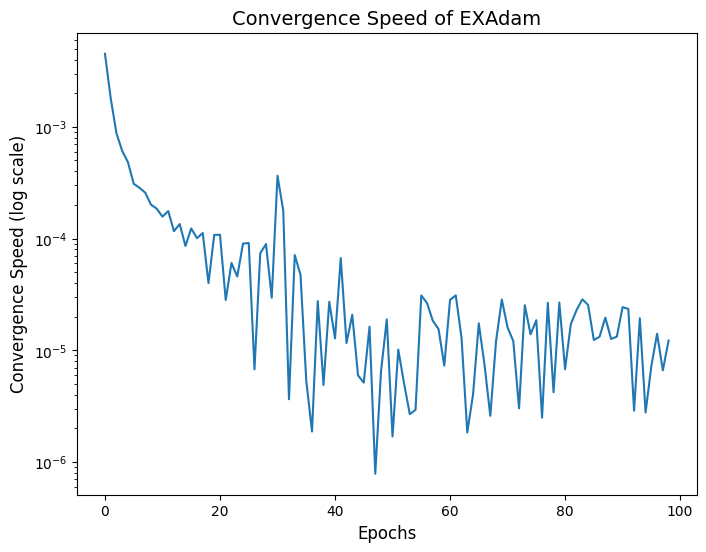

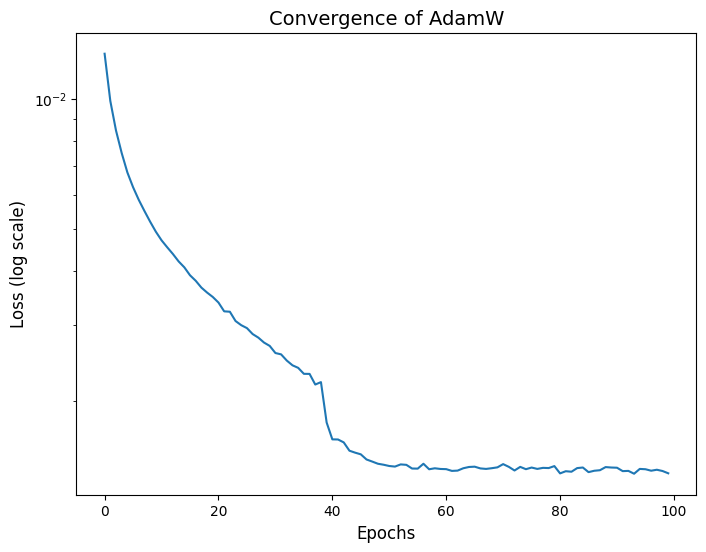

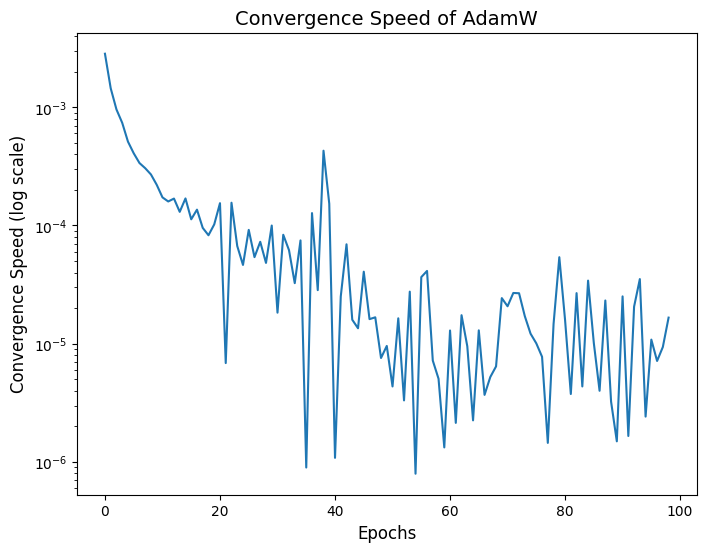

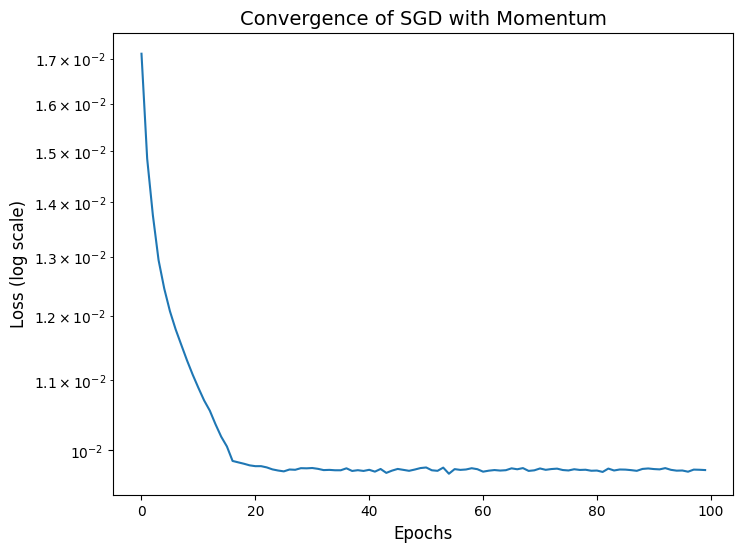

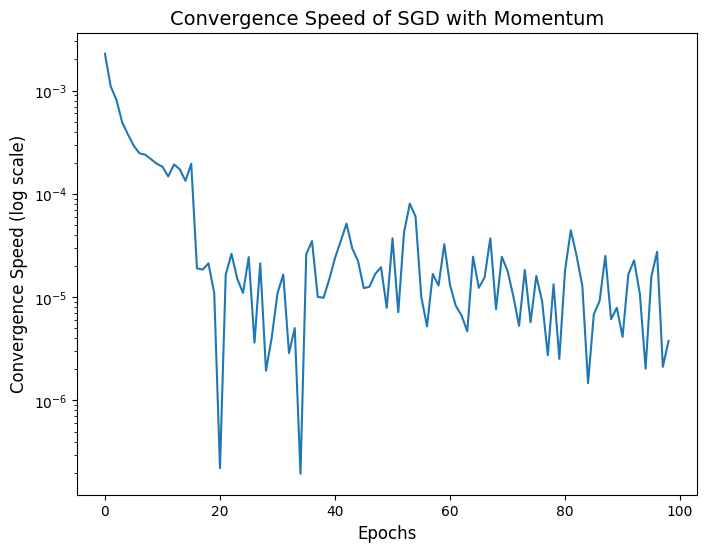

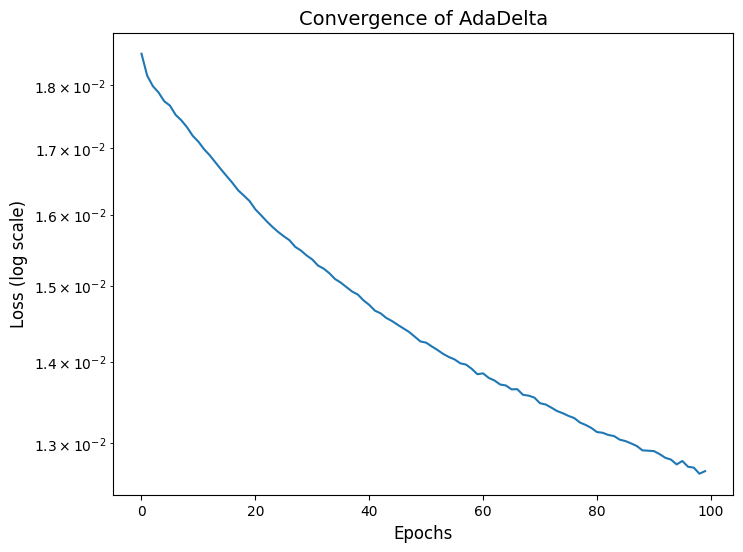

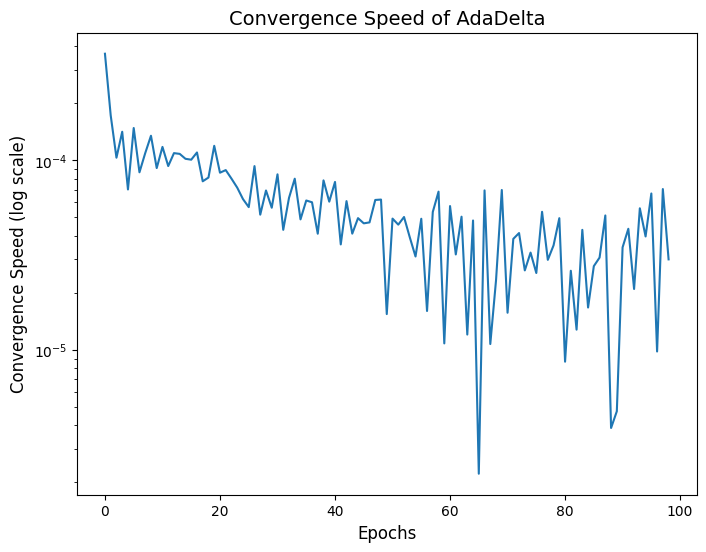

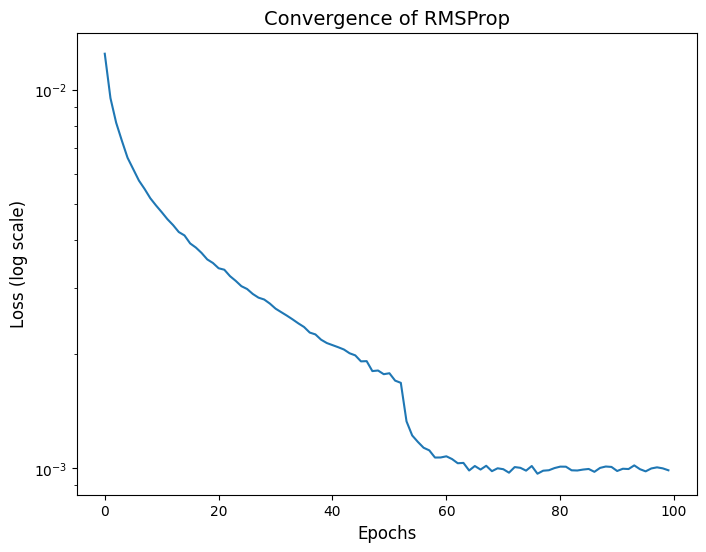

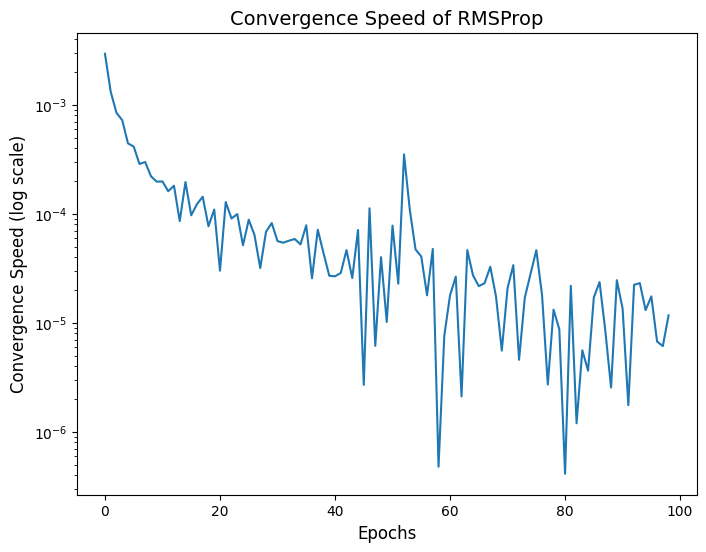

In [16]:
def plot_convergence(loss_history, optimizer_name):
    # Plot convergence
    plt.plot(loss_history)
    plt.yscale('log')  # Log scale to better see the convergence rate
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('Convergence of ' + optimizer_name)
    plt.show()

    # Calculate convergence speed
    convergence_speed = [abs(loss_history[i] - loss_history[i-1]) for i in range(1, len(loss_history))]
    # print("Convergence Speed of " + optimizer_name + ":", convergence_speed)

    # Plot convergence speed
    plt.plot(convergence_speed)
    plt.yscale('log')  # Log scale to better see the convergence rate
    plt.xlabel('Epochs')
    plt.ylabel('Convergence Speed (log scale)')
    plt.title("Convergence Speed of " + optimizer_name)
    plt.show()

    return convergence_speed

adam_convergence_speed = plot_convergence(adam_loss_hist, "Adam")
# nadam_convergence_speed = plot_convergence(nadam_loss_hist, "NAdam")
exadam_convergence_speed = plot_convergence(exadam_loss_hist, "EXAdam")
adamw_convergence_speed = plot_convergence(adamw_loss_hist, "AdamW")
sgd_convergence_speed = plot_convergence(sgd_loss_hist, "SGD with Momentum")
adadelta_convergence_speed = plot_convergence(adadelta_loss_hist, "AdaDelta")
rmsprop_convergence_speed = plot_convergence(rmsprop_loss_hist, "RMSProp")

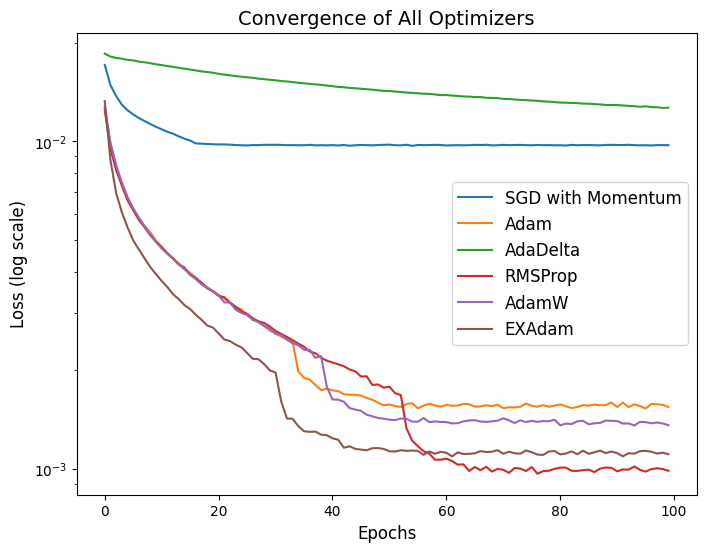

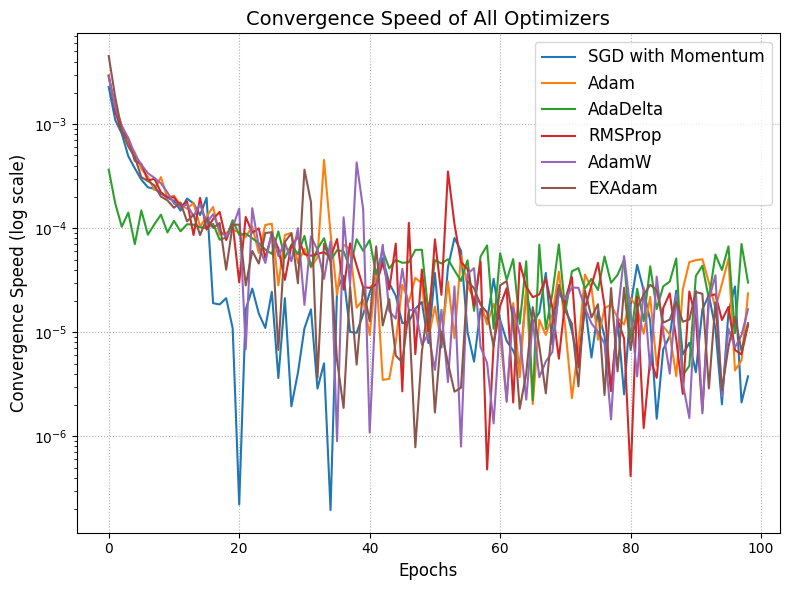

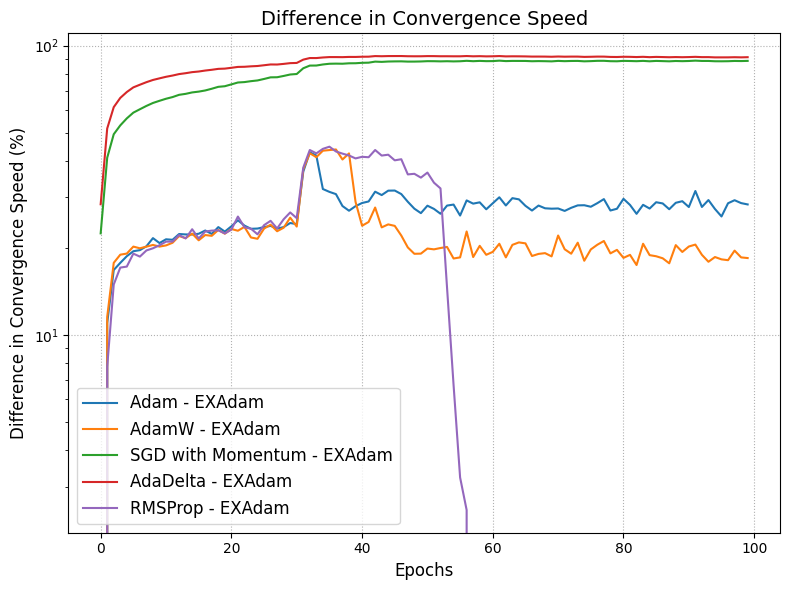

Average difference in convergence speed Adam - EXAdam: 26.472265827883156
Average difference in convergence speed AdamW - EXAdam: 22.04223785512852
Average difference in convergence speed SGD with Momentum - EXAdam: 81.45867110925528
Average difference in convergence speed AdaDelta - EXAdam: 87.20312065954924
Average difference in convergence speed RMSProp - EXAdam: 10.538326613814913


In [17]:
# Plot the convergence of all optimizers
plt.figure(figsize=(8, 6))
plt.plot(sgd_loss_hist, label="SGD with Momentum")
plt.plot(adam_loss_hist, label="Adam")
plt.plot(adadelta_loss_hist, label="AdaDelta")
plt.plot(rmsprop_loss_hist, label="RMSProp")
# plt.plot(nadam_loss_hist, label="NAdam")
plt.plot(adamw_loss_hist, label="AdamW")
plt.plot(exadam_loss_hist, label="EXAdam")

plt.yscale('log')  # Log scale to better see the convergence rate
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.title('Convergence of All Optimizers')
plt.legend()
plt.savefig('Convergence.png')
plt.show()


# Plot the convergence speed of all optimizers
plt.figure(figsize=(8, 6))
plt.plot(sgd_convergence_speed, label="SGD with Momentum")
plt.plot(adam_convergence_speed, label="Adam")
plt.plot(adadelta_convergence_speed, label="AdaDelta")
plt.plot(rmsprop_convergence_speed, label="RMSProp")
# plt.plot(nadam_convergence_speed, label="NAdam")
plt.plot(adamw_convergence_speed, label="AdamW")
plt.plot(exadam_convergence_speed, label="EXAdam")

plt.yscale('log')  # Log scale to better see the convergence rate
plt.xlabel('Epochs')
plt.ylabel('Convergence Speed (log scale)')
plt.title('Convergence Speed of All Optimizers')
plt.legend()
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('Convergence Speed.png', dpi=300)
plt.show()

# Calculate in percentage the difference in convergence speed between Adam and EXAdam and AdamW
adam_exadam_diff = [(adam_loss_hist[i] - exadam_loss_hist[i]) / adam_loss_hist[i] * 100 for i in range(len(adam_loss_hist))]
adamw_exadam_diff = [(adamw_loss_hist[i] - exadam_loss_hist[i]) / adamw_loss_hist[i] * 100 for i in range(len(adamw_loss_hist))]
sgd_exadam_diff = [(sgd_loss_hist[i] - exadam_loss_hist[i]) / sgd_loss_hist[i] * 100 for i in range(len(sgd_loss_hist))]
adadelta_exadam_diff = [(adadelta_loss_hist[i] - exadam_loss_hist[i]) / adadelta_loss_hist[i] * 100 for i in range(len(adadelta_loss_hist))]
rmsprop_exadam_diff = [(rmsprop_loss_hist[i] - exadam_loss_hist[i]) / rmsprop_loss_hist[i] * 100 for i in range(len(rmsprop_loss_hist))]
# nadam_exadam_diff = [(nadam_loss_hist[i] - exadam_loss_hist[i]) / nadam_loss_hist[i] * 100 for i in range(len(nadam_loss_hist))]

# Plot the difference in convergence speed between Adam and EXAdam and AdamW
plt.figure(figsize=(8, 6))

plt.plot(adam_exadam_diff, label="Adam - EXAdam")
plt.plot(adamw_exadam_diff, label="AdamW - EXAdam")
plt.plot(sgd_exadam_diff, label="SGD with Momentum - EXAdam")
plt.plot(adadelta_exadam_diff, label="AdaDelta - EXAdam")
plt.plot(rmsprop_exadam_diff, label="RMSProp - EXAdam")
# plt.plot(nadam_exadam_diff, label="NAdam - EXAdam")

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Difference in Convergence Speed (%)')
plt.title('Difference in Convergence Speed')
plt.legend()
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.savefig('Difference in Convergence Speed.png', dpi=300)
plt.show()

# Print the average difference in convergence speed
print("Average difference in convergence speed Adam - EXAdam:", sum(adam_exadam_diff) / len(adam_exadam_diff))
print("Average difference in convergence speed AdamW - EXAdam:", sum(adamw_exadam_diff) / len(adamw_exadam_diff))
print("Average difference in convergence speed SGD with Momentum - EXAdam:", sum(sgd_exadam_diff) / len(sgd_exadam_diff))
print("Average difference in convergence speed AdaDelta - EXAdam:", sum(adadelta_exadam_diff) / len(adadelta_exadam_diff))
print("Average difference in convergence speed RMSProp - EXAdam:", sum(rmsprop_exadam_diff) / len(rmsprop_exadam_diff))
# print("Average difference in convergence speed NAdam - EXAdam:", sum(nadam_exadam_diff) / len(nadam_exadam_diff))


In [18]:
# Calculate the number of epochs to reach the best validation accuracy of all optimizers
def epochs_to_best_val_acc(acc_hist_val):
    best_val_acc = max(acc_hist_val)
    return acc_hist_val.index(best_val_acc) + 1


adam_epochs_to_best_val_acc = epochs_to_best_val_acc(adam_acc_hist_val)
# nadam_epochs_to_best_val_acc = epochs_to_best_val_acc(nadam_acc_hist_val)
exadam_epochs_to_best_val_acc = epochs_to_best_val_acc(exadam_acc_hist_val)
adamw_epochs_to_best_val_acc = epochs_to_best_val_acc(adamw_acc_hist_val)
sgd_epochs_to_best_val_acc = epochs_to_best_val_acc(sgd_acc_hist_val)
adadelta_epochs_to_best_val_acc = epochs_to_best_val_acc(adadelta_acc_hist_val)
rmsprop_epochs_to_best_val_acc = epochs_to_best_val_acc(rmsprop_acc_hist_val)

print("Adam Epochs to Best Validation Accuracy:", adam_epochs_to_best_val_acc)
# print("NAdam Epochs to Best Validation Accuracy:", nadam_epochs_to_best_val_acc)
print("EXAdam Epochs to Best Validation Accuracy:", exadam_epochs_to_best_val_acc)
print("AdamW Epochs to Best Validation Accuracy:", adamw_epochs_to_best_val_acc)
print("SGD with Momentum Epochs to Best Validation Accuracy:", sgd_epochs_to_best_val_acc)
print("AdaDelta Epochs to Best Validation Accuracy:", adadelta_epochs_to_best_val_acc)
print("RMSProp Epochs to Best Validation Accuracy:", rmsprop_epochs_to_best_val_acc)


# Calculate the number of epochs to reach the best training accuracy of all optimizers
def epochs_to_best_train_acc(acc_hist):
    best_train_acc = max(acc_hist)
    return acc_hist.index(best_train_acc) + 1


adam_epochs_to_best_train_acc = epochs_to_best_train_acc(adam_acc_hist)
# nadam_epochs_to_best_train_acc = epochs_to_best_train_acc(nadam_acc_hist)
exadam_epochs_to_best_train_acc = epochs_to_best_train_acc(exadam_acc_hist)
adamw_epochs_to_best_train_acc = epochs_to_best_train_acc(adamw_acc_hist)
sgd_epochs_to_best_train_acc = epochs_to_best_train_acc(sgd_acc_hist)
adadelta_epochs_to_best_train_acc = epochs_to_best_train_acc(adadelta_acc_hist)
rmsprop_epochs_to_best_train_acc = epochs_to_best_train_acc(rmsprop_acc_hist)

print("Adam Epochs to Best Training Accuracy:", adam_epochs_to_best_train_acc)
# print("NAdam Epochs to Best Training Accuracy:", nadam_epochs_to_best_train_acc)
print("EXAdam Epochs to Best Training Accuracy:", exadam_epochs_to_best_train_acc)
print("AdamW Epochs to Best Training Accuracy:", adamw_epochs_to_best_train_acc)
print("SGD with Momentum Epochs to Best Training Accuracy:", sgd_epochs_to_best_train_acc)
print("AdaDelta Epochs to Best Training Accuracy:", adadelta_epochs_to_best_train_acc)
print("RMSProp Epochs to Best Training Accuracy:", rmsprop_epochs_to_best_train_acc)


Adam Epochs to Best Validation Accuracy: 66
EXAdam Epochs to Best Validation Accuracy: 55
AdamW Epochs to Best Validation Accuracy: 99
SGD with Momentum Epochs to Best Validation Accuracy: 10
AdaDelta Epochs to Best Validation Accuracy: 96
RMSProp Epochs to Best Validation Accuracy: 56
Adam Epochs to Best Training Accuracy: 84
EXAdam Epochs to Best Training Accuracy: 81
AdamW Epochs to Best Training Accuracy: 94
SGD with Momentum Epochs to Best Training Accuracy: 26
AdaDelta Epochs to Best Training Accuracy: 99
RMSProp Epochs to Best Training Accuracy: 87


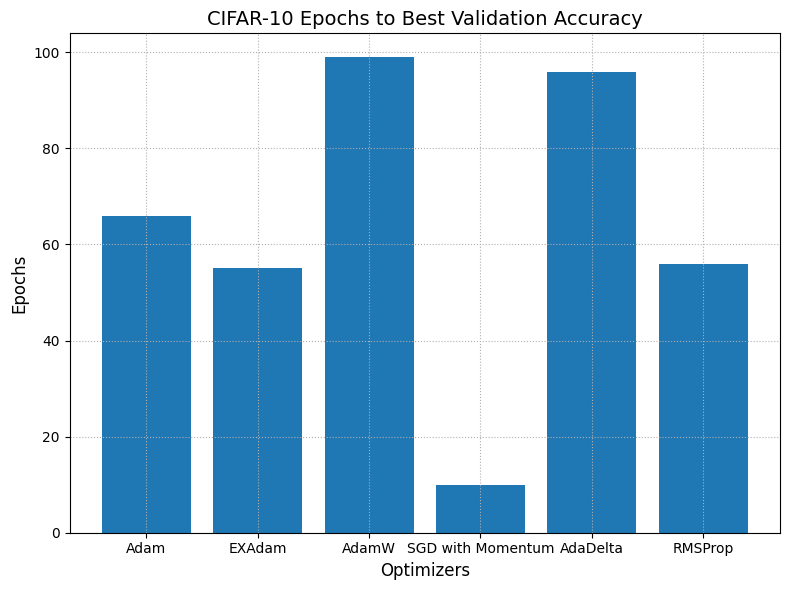

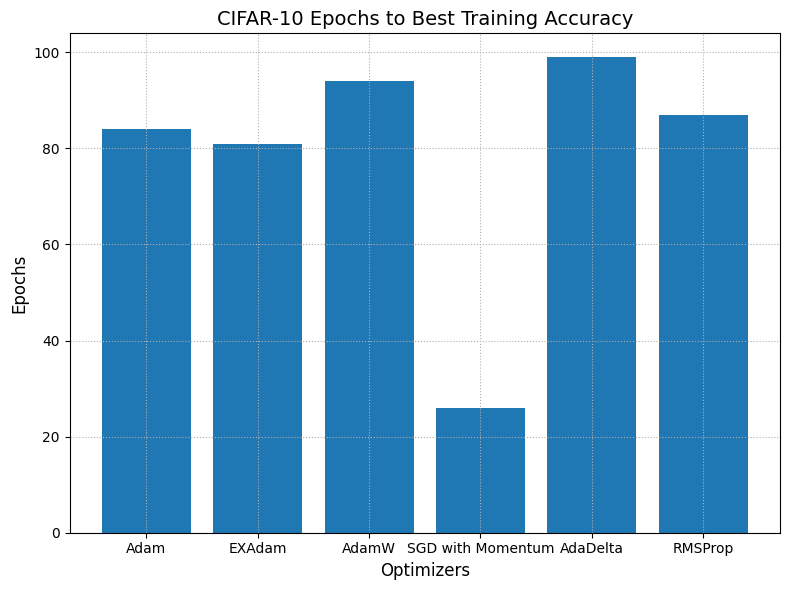

In [19]:
optimizers = [
    "Adam",
    # "NAdam",
    "EXAdam",
    "AdamW",
    "SGD with Momentum",
    "AdaDelta",
    "RMSProp",
]

# Plot the number of epochs to reach the best validation accuracy of all optimizers
epochs_to_best_val_accs = [
    adam_epochs_to_best_val_acc,
    # nadam_epochs_to_best_val_acc,
    exadam_epochs_to_best_val_acc,
    adamw_epochs_to_best_val_acc,
    sgd_epochs_to_best_val_acc,
    adadelta_epochs_to_best_val_acc,
    rmsprop_epochs_to_best_val_acc,
]
plt.figure(figsize=(8, 6))
plt.bar(optimizers, epochs_to_best_val_accs)
plt.title("CIFAR-10 Epochs to Best Validation Accuracy")
plt.xlabel("Optimizers")
plt.ylabel("Epochs")
plt.grid(linestyle='dotted')
plt.tight_layout()
plt.show()

# Plot the number of epochs to reach the best training accuracy of all optimizers
epochs_to_best_train_accs = [
    adam_epochs_to_best_train_acc,
    # nadam_epochs_to_best_train_acc,
    exadam_epochs_to_best_train_acc,
    adamw_epochs_to_best_train_acc,
    sgd_epochs_to_best_train_acc,
    adadelta_epochs_to_best_train_acc,
    rmsprop_epochs_to_best_train_acc,
]
plt.figure(figsize=(8, 6))
plt.bar(optimizers, epochs_to_best_train_accs)
plt.title("CIFAR-10 Epochs to Best Training Accuracy")
plt.xlabel("Optimizers")
plt.ylabel("Epochs")
plt.grid(linestyle='dotted')
plt.tight_layout()

plt.show()